In [24]:
import scanpy as sc
import json
import scvi_v2
import flax.linen as nn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scib_metrics

In [2]:
from scib_metrics import kbet, silhouette_batch
from scib_metrics.benchmark import Benchmarker

In [3]:
# adata = sc.read_h5ad("/data1/scvi-v2-reproducibility/results/aws_pipeline/data/haniffa.preprocessed.h5ad")
adata = sc.read_h5ad("/home/justin/ghrepos/scvi-v2-reproducibility/results/aws_pipeline/data/pbmcs68k.preprocessed.h5ad")
sc.pp.subsample(adata, n_obs=40000)
adata

with open("/home/justin/ghrepos/scvi-v2-reproducibility/conf/datasets/pbmcs68k.json", 'r') as file:
    config_in = json.load(file)

train_kwargs = config_in["scviv2_train_kwargs"]

train_kwargs= {
    'max_epochs': 400,
    'batch_size': 1024,
    'early_stopping': True,
    'early_stopping_patience': 30,
    'early_stopping_monitor': "validation_loss",
    'check_val_every_n_epoch': 1,
    'plan_kwargs': {'n_epochs_kl_warmup': 15, "lr": 1e-3}
}


In [4]:
adata

AnnData object with n_obs × n_vars = 40000 × 3000
    obs: 'n_counts', 'leiden', '_scvi_batch', '_scvi_labels', 'sample_assignment', 'subcluster_assignment', 'Site'
    var: 'gene_ids', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cluster0_tree_gt', 'hvg', 'leiden', 'neighbors'
    obsm: 'X_scvi'
    obsp: 'connectivities', 'distances'

In [5]:
# Subsample some samples from each subcluster assignment group
sample_assignment = adata.obs[["sample_assignment", "subcluster_assignment"]].drop_duplicates(keep="first")
sample_assignment = sample_assignment[sample_assignment.subcluster_assignment != "NA"]
sample_assignment.head()

,sample_assignment,subcluster_assignment
CATTGACTTTGCTT-4,25,4
TAGGCAACTAAGGA-1,26,4
CCCTTACTCTTGTT-6,28,4
CCCTCAGACTGACA-4,18,3
GTCGAATGGGTATC-7,23,3


In [6]:
sample_assignment["subcluster_assignment"] = sample_assignment["subcluster_assignment"].astype(str).astype("category")
sample_assignment["sample_assignment_int"] = sample_assignment.sample_assignment.astype(int)
sample_assignment['rank'] = sample_assignment.groupby('subcluster_assignment')['sample_assignment_int'].rank(method='dense', ascending=True).astype(int)
sample_assignment.sort_values(["subcluster_assignment", "rank"])

,sample_assignment,subcluster_assignment,sample_assignment_int,rank
CGTCAAGATGCAGT-7,1,1,1,1
CGCTACACTCGCTC-2,2,1,2,2
ACAGTGTGTACTGG-3,3,1,3,3
TGAAATTGTCTCAT-7,4,1,4,4
CGAGAACTAGCACT-3,5,1,5,5
TTCCATGACGAATC-7,6,1,6,6
CACATACTTACGCA-5,7,1,7,7
GAGATAGAGCTGAT-4,8,1,8,8
TCCTATGACCAGTA-5,9,2,9,1
GAAATACTGGCATT-1,10,2,10,2


In [76]:
subsample_cluster = 1
subsample_rates = [0.1, 0.3, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0]
subsampled_adatas = [adata[adata.obs.leiden != str(subsample_cluster)]]
for rankminusone, subsample_rate in enumerate(subsample_rates):
    rank = rankminusone + 1
    samples_to_subsample = sample_assignment[sample_assignment["rank"] == rank]["sample_assignment"].to_list()
    for sample in samples_to_subsample:
        subsample_adata = adata[(adata.obs.sample_assignment == str(sample)) & (adata.obs["leiden"] == str(subsample_cluster))]
        subsample_adata = subsample_adata[np.random.choice(subsample_adata.shape[0], int(subsample_adata.shape[0] * subsample_rate), replace=False)]
        subsampled_adatas.append(subsample_adata)
sadata = sc.concat(subsampled_adatas)
sadata

AnnData object with n_obs × n_vars = 37724 × 3000
    obs: 'n_counts', 'leiden', '_scvi_batch', '_scvi_labels', 'sample_assignment', 'subcluster_assignment', 'Site'
    obsm: 'X_scvi'

In [77]:
sadata.obs.sample_assignment.value_counts()

30    2425
31    2396
29    2380
28    2368
32    2355
27    2310
26    2129
25    2116
21    1478
22    1452
24    1446
23    1401
20    1377
19    1355
17    1192
18    1191
12     669
15     652
13     650
16     637
14     637
4      588
7      576
6      552
8      527
5      513
11     496
10     450
3      401
9      373
2      351
1      281
Name: sample_assignment, dtype: int64

In [78]:
scvi_v2.MrVI.setup_anndata(sadata, batch_key=config_in["batch_key"], sample_key=config_in["sample_key"])

## Model training

### HD

In [79]:
model_linear = scvi_v2.MrVI(
    sadata, 
    **{
        "qz_nn_flavor": "linear",
        # "px_nn_flavor": "attention",
        # "qz_kwargs": {"use_map": False, "stop_gradients": True},
        # "px_kwargs": {"stop_gradients": True, "stop_gradients_mlp": False, "h_activation": nn.softmax},
        # "learn_z_u_prior_scale": True,
    }
)
model_linear.train(**train_kwargs)

INFO     Jax module moved to GPU. Note: Pytorch lightning will show GPU is not being used for the Trainer.         


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 336/400:  84%|████████▍ | 336/400 [01:39<00:18,  3.37it/s, v_num=1, train_loss_step=263, train_loss_epoch=270]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 271.562. Signaling Trainer to stop.


In [80]:
model_attention = scvi_v2.MrVI(
    sadata, 
    **{
        "qz_nn_flavor": "attention",
        "qz_kwargs": {"use_map": False, "stop_gradients": True, "stop_gradients_mlp": False},
        # "px_kwargs": {"stop_gradients": True, "stop_gradients_mlp": False, "h_activation": nn.softmax},
        # "learn_z_u_prior_scale": True,
    }
)
model_attention.train(**train_kwargs)

INFO     Jax module moved to GPU. Note: Pytorch lightning will show GPU is not being used for the Trainer.         


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [02:09<00:00,  3.39it/s, v_num=1, train_loss_step=261, train_loss_epoch=257]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:09<00:00,  3.08it/s, v_num=1, train_loss_step=261, train_loss_epoch=257]


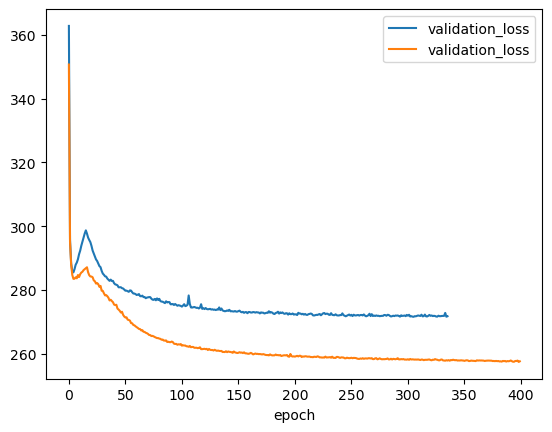

In [81]:
ax = model_linear.history_["validation_loss"].plot()
ax = model_attention.history_["validation_loss"].plot(ax=ax)
# ax = model_linear.history["validation_loss"].plot(ax=ax)
# plt.ylim(1300, 1800)

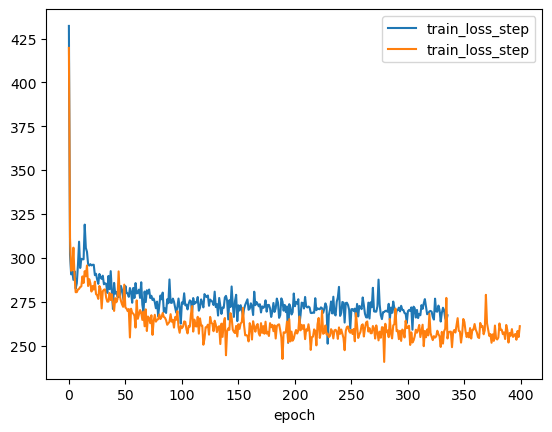

In [82]:
ax = model_linear.history["train_loss_step"].plot()
ax = model_attention.history["train_loss_step"].plot(ax=ax)
# ax = model_linear.history["train_loss_step"].plot(ax=ax)
# plt.ylim(900, 1000)
# plt.xlim(0, 25)

In [83]:
latent_linear = model_linear.get_latent_representation()
latent_attention = model_attention.get_latent_representation()
# latent_sgmlp = model_sgmlp.get_latent_representation()

z_latent_linear = model_linear.get_latent_representation(give_z=True)
z_latent_attention = model_attention.get_latent_representation(give_z=True)
# z_latent_sgmlp = model_sgmlp.get_latent_representation(give_z=True)


100%|██████████| 295/295 [00:01<00:00, 251.56it/s]


### Plot u spaces

/home/justin/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/justin/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


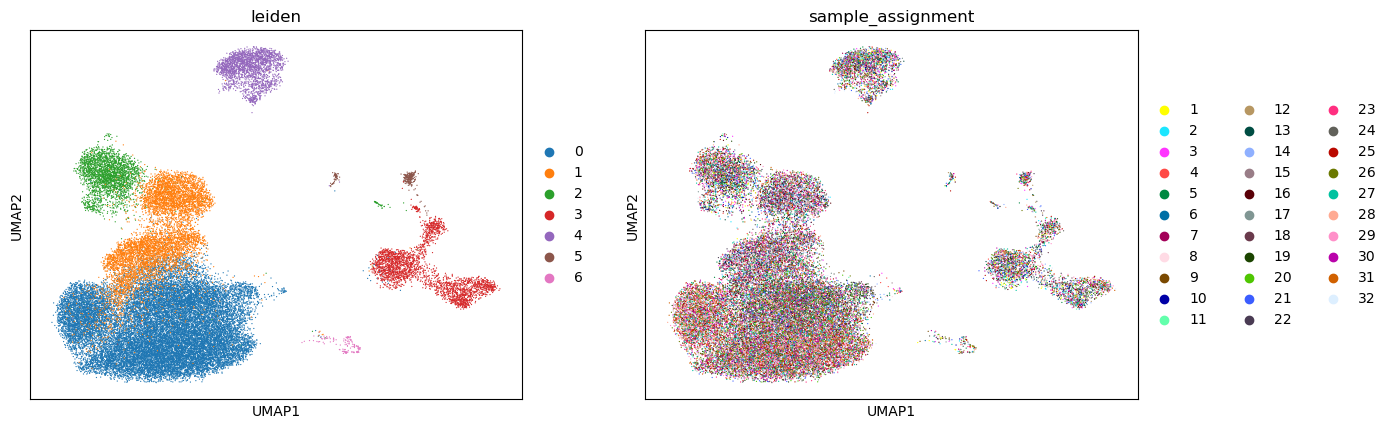

In [84]:
sadata.obsm["X_scvi"] = latent_linear
sc.pp.neighbors(sadata, use_rep="X_scvi")
sc.tl.umap(sadata)
sc.pl.umap(sadata, color=["leiden", "sample_assignment"])

/home/justin/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/justin/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


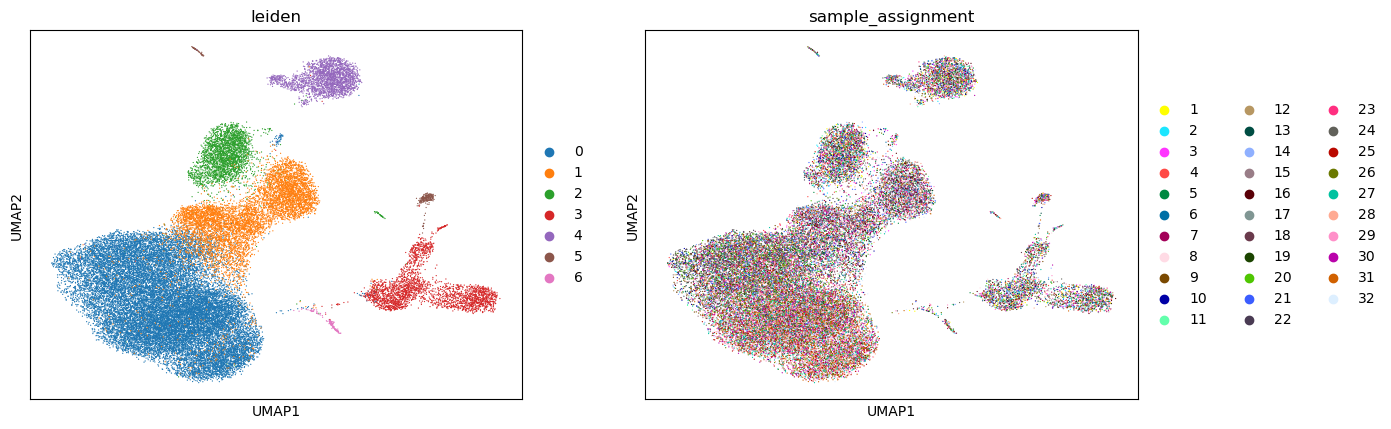

In [85]:
sadata.obsm["X_scvi"] = latent_attention
sc.pp.neighbors(sadata, use_rep="X_scvi")
sc.tl.umap(sadata)
sc.pl.umap(sadata, color=["leiden", "sample_assignment"])

### Plot z spaces

/home/justin/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/justin/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


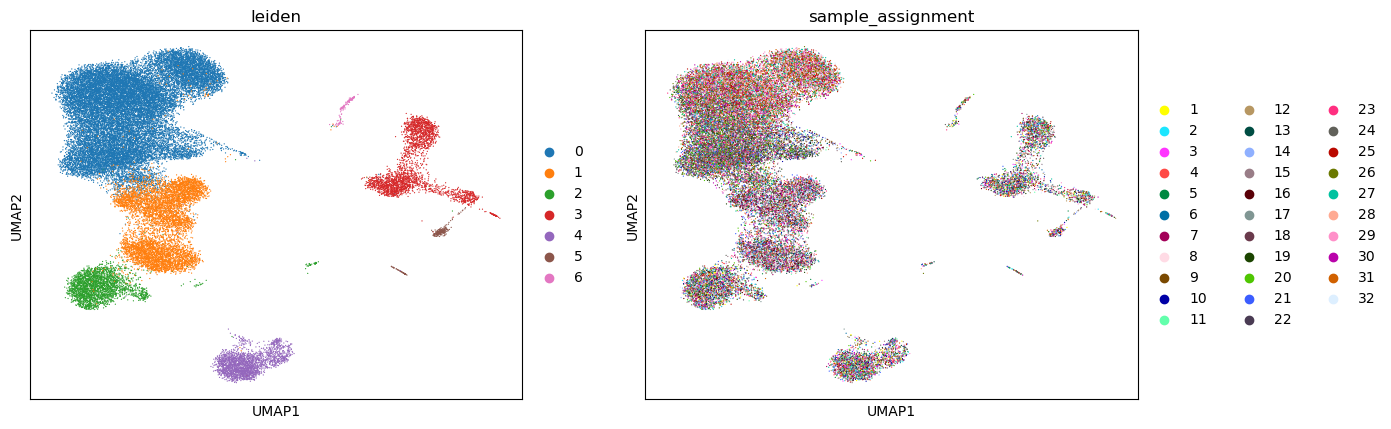

In [86]:
sadata.obsm["X_scvi"] = z_latent_linear
sc.pp.neighbors(sadata, use_rep="X_scvi")
sc.tl.umap(sadata)
sc.pl.umap(sadata, color=["leiden", "sample_assignment"])

/home/justin/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/justin/miniconda3/envs/run-models/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


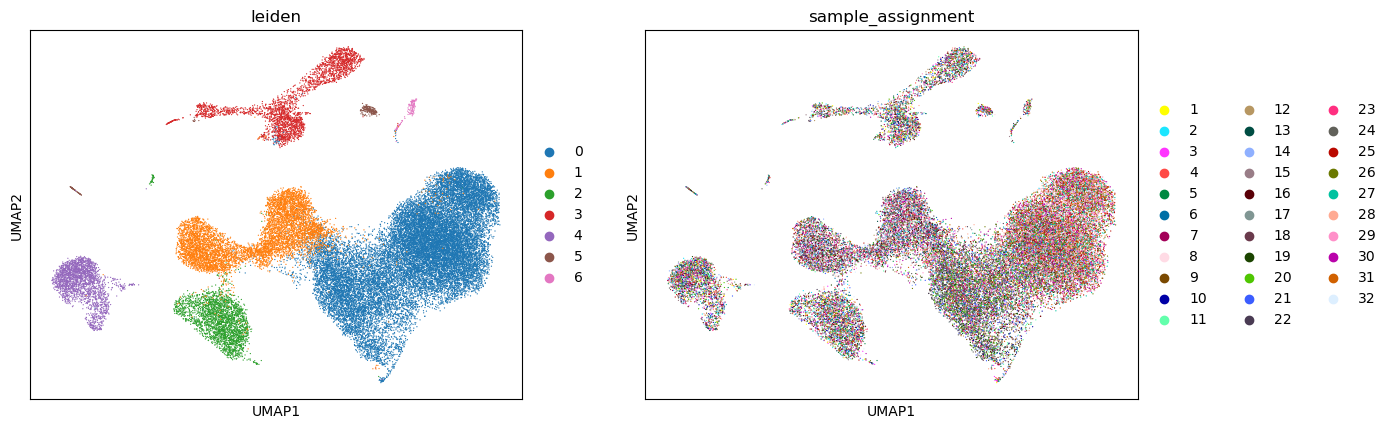

In [87]:
sadata.obsm["X_scvi"] = z_latent_attention
sc.pp.neighbors(sadata, use_rep="X_scvi")
sc.tl.umap(sadata)
sc.pl.umap(sadata, color=["leiden", "sample_assignment"])

## DMats

In [106]:
import sys

sys.path.append("../bin")

import seaborn as sns

from tree_utils import hierarchical_clustering, linkage_to_ete
from scipy.cluster.hierarchy import fcluster

In [107]:
d = model_linear.get_local_sample_distances(
    sadata,
    use_mean=True,
    normalize_distances=False,
    keep_cell=True,
    groupby="leiden",
)

100%|██████████| 148/148 [00:13<00:00, 10.57it/s]


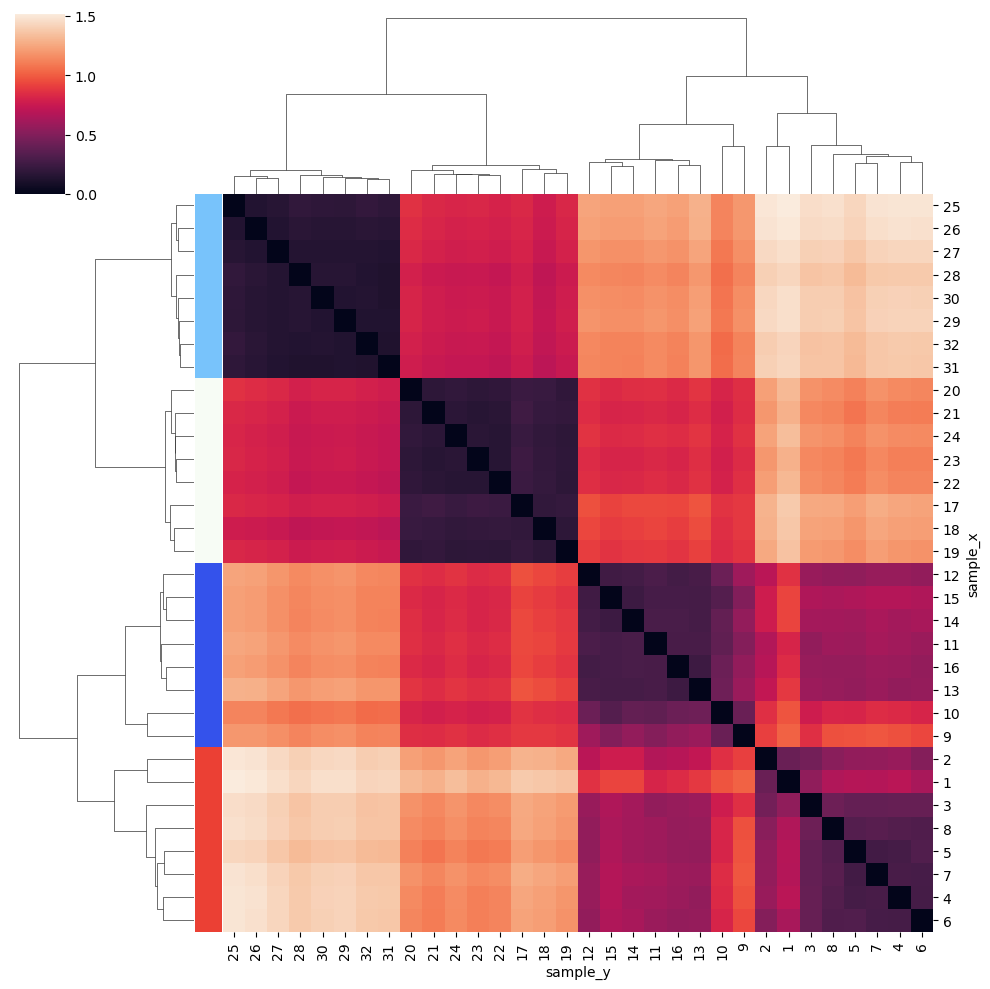

In [108]:
selected_leiden = "0"

d1 = d.loc[dict(leiden_name=selected_leiden)]["leiden"]
d1 = d1.loc[dict(sample_x=sample_assignment["sample_assignment"].values)].loc[dict(sample_y=sample_assignment["sample_assignment"].values)]
Z = hierarchical_clustering(d1.values, method="complete", return_ete=False)
clusters = fcluster(Z, t=3, criterion="maxclust")
cluster_info = sample_assignment["subcluster_assignment"].values
cluster_colors = cluster_info.map({'1': "#eb4034", '2': "#3452eb", '3': "#f7fcf5", '4': "#78C3FB"})
sns.clustermap(d1.to_pandas(), row_linkage=Z, col_linkage=Z, row_colors=cluster_colors)

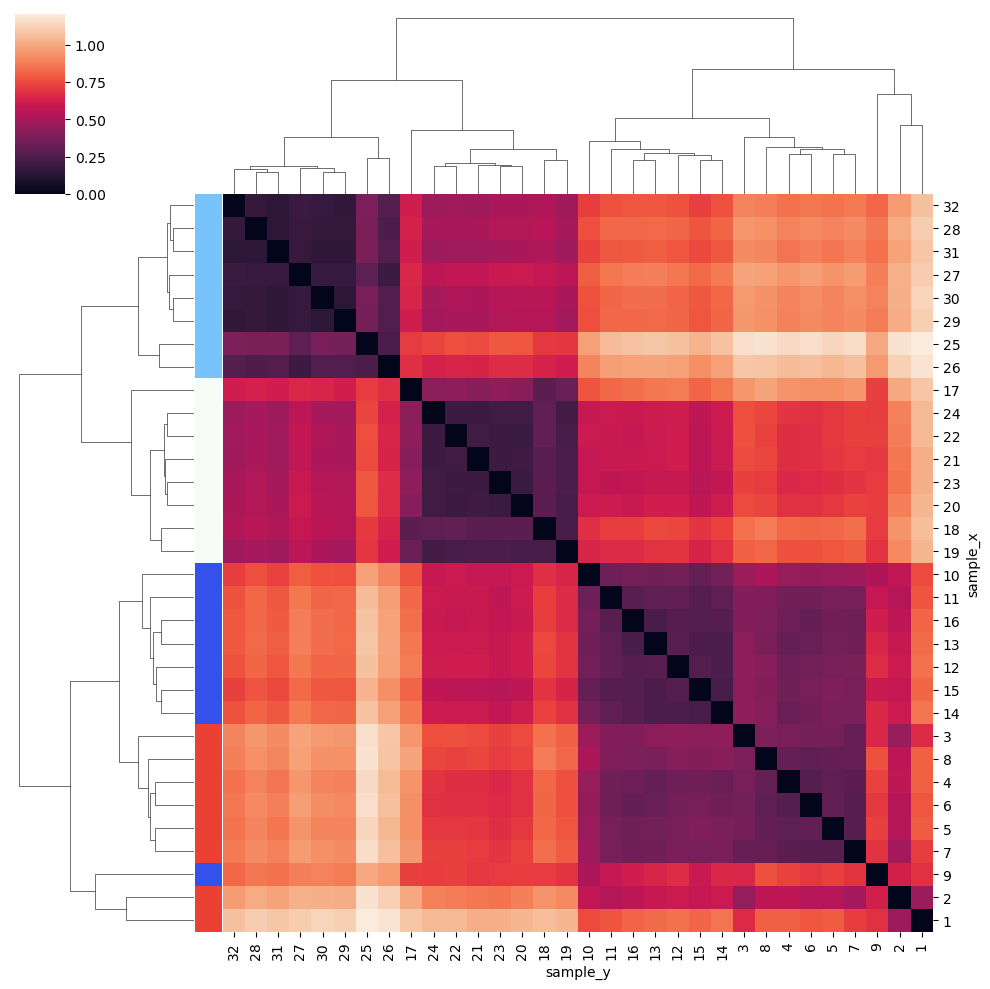

In [109]:
selected_leiden = "1"

d1 = d.loc[dict(leiden_name=selected_leiden)]["leiden"]
d1 = d1.loc[dict(sample_x=sample_assignment["sample_assignment"].values)].loc[dict(sample_y=sample_assignment["sample_assignment"].values)]
Z = hierarchical_clustering(d1.values, method="complete", return_ete=False)
clusters = fcluster(Z, t=3, criterion="maxclust")
cluster_info = sample_assignment["subcluster_assignment"].values
cluster_colors = cluster_info.map({'1': "#eb4034", '2': "#3452eb", '3': "#f7fcf5", '4': "#78C3FB"})
sns.clustermap(d1.to_pandas(), row_linkage=Z, col_linkage=Z, row_colors=cluster_colors)

In [110]:
# Plot variance of dist to sample 8 per rank
sample_8_dists = d.cell.sel(sample_y="8")
print(sample_8_dists.values.shape)

sample_8_dists_df = pd.DataFrame(sample_8_dists.values, columns=sample_8_dists.sample_x.values)
sample_8_dists_df["leiden"] = sadata.obs.leiden.astype(int).to_numpy()
sample_8_dists_df

(37724, 32)


,1,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,31,32,leiden
0,0.415010,0.407487,0.351131,0.376694,0.319279,0.306671,0.232355,0.0,0.511408,0.474526,...,0.666030,0.893128,0.899732,0.888008,0.811040,0.918298,0.910399,0.849271,0.810698,4
1,0.531287,0.369963,0.419094,0.349639,0.292053,0.302563,0.292283,0.0,0.802731,0.679614,...,0.932211,1.098917,1.069090,1.032044,0.988895,0.982202,1.009499,0.962815,0.969712,0
2,0.455857,0.492410,0.511392,0.388119,0.431399,0.303967,0.235458,0.0,0.537686,0.476719,...,0.776690,1.011581,1.040946,1.046507,0.920445,1.079611,1.034891,1.008928,0.922082,4
3,0.600317,0.566598,0.392708,0.263260,0.299850,0.244495,0.240974,0.0,0.767339,0.688348,...,1.137170,1.533744,1.527433,1.479048,1.448992,1.464549,1.458412,1.437865,1.441267,0
4,0.600152,0.498968,0.480412,0.340223,0.412433,0.340674,0.374863,0.0,1.108917,0.955928,...,1.349464,1.670424,1.645524,1.593027,1.576711,1.607117,1.607974,1.578801,1.567746,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37719,0.831670,0.561564,0.359020,0.301123,0.353563,0.311026,0.351377,0.0,0.728394,0.542523,...,0.743853,1.263370,1.094285,0.946238,0.890912,0.894173,0.895846,0.842974,0.844372,1
37720,0.758840,0.533937,0.508977,0.411102,0.336974,0.317355,0.386151,0.0,0.605577,0.467362,...,0.560649,1.169086,1.104643,1.051587,0.974192,0.986616,0.979188,0.971359,0.973978,1
37721,0.735115,0.490906,0.382200,0.220189,0.287161,0.322260,0.324674,0.0,0.927426,0.672021,...,0.978731,1.343195,1.291031,1.237780,1.184169,1.204333,1.191869,1.172115,1.159378,1
37722,0.865377,0.628923,0.581814,0.364394,0.416528,0.421295,0.428299,0.0,1.127380,0.862303,...,1.164363,1.467866,1.400869,1.358688,1.278316,1.323138,1.319040,1.290834,1.306155,1


In [117]:
for rank in [1, 2, 3, 4, 5, 6, 7, 8]:
    samples_in_rank = sample_assignment[(sample_assignment["rank"] == rank) & (sample_assignment["subcluster_assignment"] == "1")]["sample_assignment"].values
    sample_8_dists_df[f"rank_{rank}"] = sample_8_dists_df[samples_in_rank].mean(axis=1)
for cluster in sample_assignment["subcluster_assignment"].unique():
    samples_in_cluster = sample_assignment[sample_assignment["subcluster_assignment"] == cluster]["sample_assignment"].values
    sample_8_dists_df[f"cluster_{cluster}"] = sample_8_dists_df[samples_in_cluster].mean(axis=1)
sample_8_dists_df

,1,2,3,4,5,6,7,8,9,10,...,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,cluster_4,cluster_3,cluster_2,cluster_1
0,0.415010,0.407487,0.351131,0.376694,0.319279,0.306671,0.232355,0.0,0.511408,0.474526,...,0.351131,0.376694,0.319279,0.306671,0.232355,0.0,0.872572,0.622556,0.390090,0.301078
1,0.531287,0.369963,0.419094,0.349639,0.292053,0.302563,0.292283,0.0,0.802731,0.679614,...,0.419094,0.349639,0.292053,0.302563,0.292283,0.0,1.014147,0.962374,0.578656,0.319610
2,0.455857,0.492410,0.511392,0.388119,0.431399,0.303967,0.235458,0.0,0.537686,0.476719,...,0.511392,0.388119,0.431399,0.303967,0.235458,0.0,1.008124,0.721905,0.398905,0.352325
3,0.600317,0.566598,0.392708,0.263260,0.299850,0.244495,0.240974,0.0,0.767339,0.688348,...,0.392708,0.263260,0.299850,0.244495,0.240974,0.0,1.473914,1.133160,0.554095,0.326025
4,0.600152,0.498968,0.480412,0.340223,0.412433,0.340674,0.374863,0.0,1.108917,0.955928,...,0.480412,0.340223,0.412433,0.340674,0.374863,0.0,1.605915,1.364804,0.762827,0.380966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37719,0.831670,0.561564,0.359020,0.301123,0.353563,0.311026,0.351377,0.0,0.728394,0.542523,...,0.359020,0.301123,0.353563,0.311026,0.351377,0.0,0.959021,0.823385,0.452849,0.383668
37720,0.758840,0.533937,0.508977,0.411102,0.336974,0.317355,0.386151,0.0,0.605577,0.467362,...,0.508977,0.411102,0.336974,0.317355,0.386151,0.0,1.026331,0.616028,0.445730,0.406667
37721,0.735115,0.490906,0.382200,0.220189,0.287161,0.322260,0.324674,0.0,0.927426,0.672021,...,0.382200,0.220189,0.287161,0.322260,0.324674,0.0,1.222984,1.005051,0.533395,0.345313
37722,0.865377,0.628923,0.581814,0.364394,0.416528,0.421295,0.428299,0.0,1.127380,0.862303,...,0.581814,0.364394,0.416528,0.421295,0.428299,0.0,1.343113,1.197084,0.699267,0.463329


<Axes: xlabel='rank', ylabel='value'>

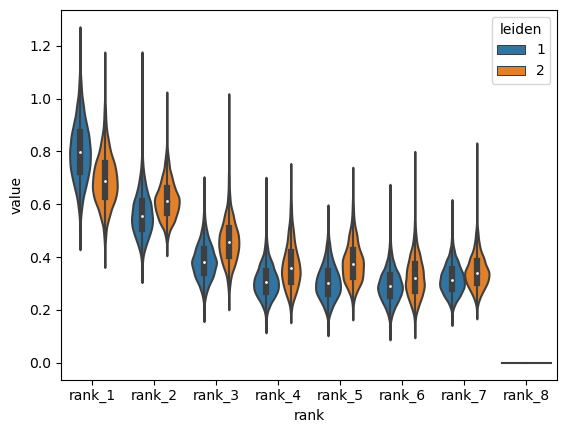

In [118]:
sample_8_dists_melt_df = pd.melt(sample_8_dists_df, id_vars=["leiden"], value_vars=[f"rank_{rank}" for rank in [1, 2, 3, 4, 5, 6, 7, 8]], var_name="rank")
sub_melt_df = sample_8_dists_melt_df[sample_8_dists_melt_df["leiden"].isin([1, 2])]
sns.violinplot(x="rank", y="value", hue="leiden", data=sub_melt_df)

<Axes: xlabel='cluster', ylabel='value'>

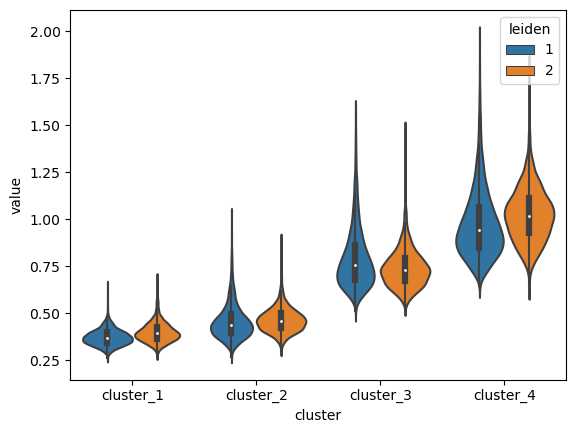

In [116]:
sample_8_dists_melt_df = pd.melt(sample_8_dists_df, id_vars=["leiden"], value_vars=[f"cluster_{cluster}" for cluster in range(1, 5)], var_name="cluster")
sub_melt_df = sample_8_dists_melt_df[sample_8_dists_melt_df["leiden"].isin([1, 2])]
sns.violinplot(x="cluster", y="value", hue="leiden", data=sub_melt_df)

In [119]:
d_att = model_attention.get_local_sample_distances(
    sadata,
    use_mean=True,
    normalize_distances=False,
    keep_cell=True,
    groupby="leiden",
)

100%|██████████| 148/148 [00:14<00:00,  9.87it/s]


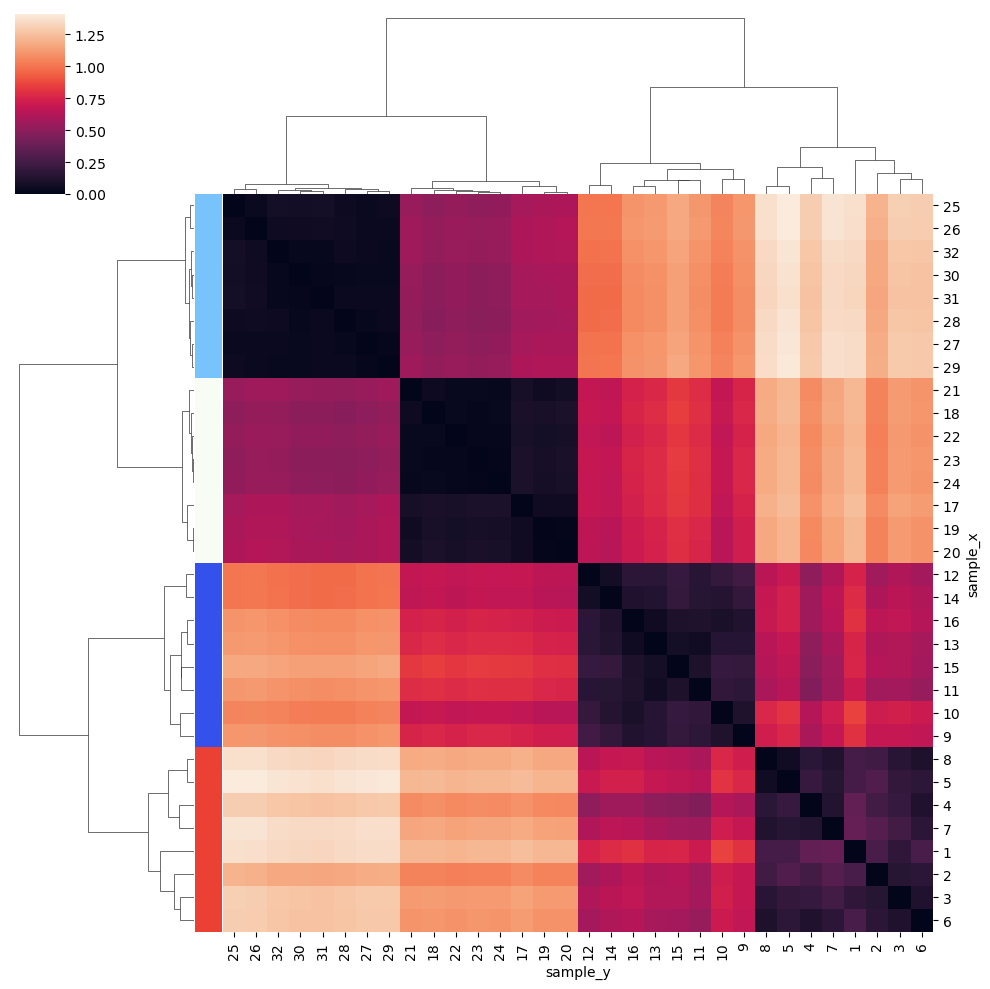

In [120]:
selected_leiden = "0"

d1 = d_att.loc[dict(leiden_name=selected_leiden)]["leiden"]
d1 = d1.loc[dict(sample_x=sample_assignment["sample_assignment"].values)].loc[dict(sample_y=sample_assignment["sample_assignment"].values)]
Z = hierarchical_clustering(d1.values, method="complete", return_ete=False)
clusters = fcluster(Z, t=3, criterion="maxclust")
cluster_info = sample_assignment["subcluster_assignment"].values
cluster_colors = cluster_info.map({'1': "#eb4034", '2': "#3452eb", '3': "#f7fcf5", '4': "#78C3FB"})
sns.clustermap(d1.to_pandas(), row_linkage=Z, col_linkage=Z, row_colors=cluster_colors)

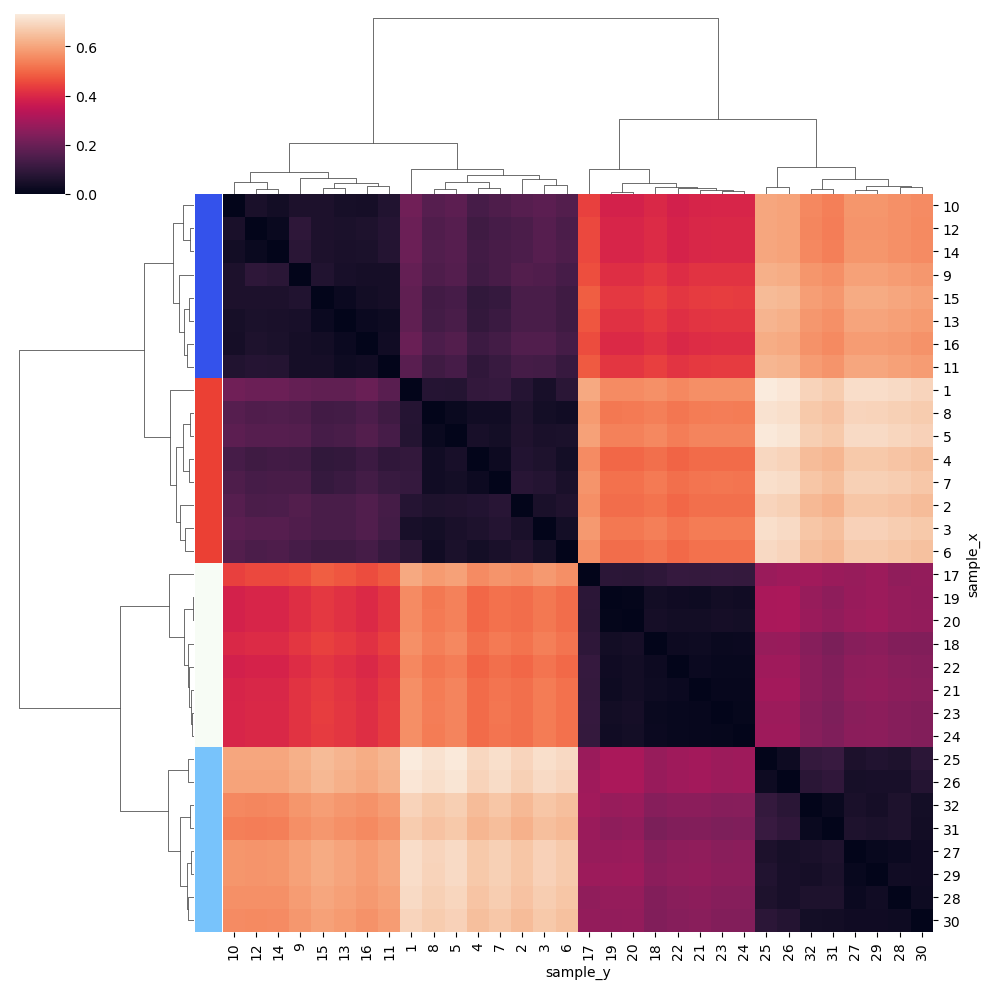

In [121]:
selected_leiden = "1"

d1 = d_att.loc[dict(leiden_name=selected_leiden)]["leiden"]
d1 = d1.loc[dict(sample_x=sample_assignment["sample_assignment"].values)].loc[dict(sample_y=sample_assignment["sample_assignment"].values)]
Z = hierarchical_clustering(d1.values, method="complete", return_ete=False)
clusters = fcluster(Z, t=3, criterion="maxclust")
cluster_info = sample_assignment["subcluster_assignment"].values
cluster_colors = cluster_info.map({'1': "#eb4034", '2': "#3452eb", '3': "#f7fcf5", '4': "#78C3FB"})
sns.clustermap(d1.to_pandas(), row_linkage=Z, col_linkage=Z, row_colors=cluster_colors)

In [122]:
# Plot variance of dist to sample 8 per rank
sample_8_dists = d_att.cell.sel(sample_y="8")
print(sample_8_dists.values.shape)

sample_8_dists_df = pd.DataFrame(sample_8_dists.values, columns=sample_8_dists.sample_x.values)
sample_8_dists_df["leiden"] = sadata.obs.leiden.astype(int).to_numpy()
sample_8_dists_df

(37724, 32)


,1,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,31,32,leiden
0,0.249419,0.043706,0.099203,0.040313,0.012101,0.025917,0.069982,0.0,0.191819,0.093966,...,0.165806,0.336361,0.323381,0.277185,0.270680,0.273782,0.253247,0.253947,0.258674,4
1,0.375093,0.368253,0.255097,0.410113,0.100990,0.169729,0.171024,0.0,1.592772,1.587106,...,1.738630,2.118208,2.132665,2.100598,2.092844,2.108668,2.088645,2.074935,2.094797,0
2,0.054261,0.045668,0.038005,0.019234,0.008440,0.016986,0.023553,0.0,0.097130,0.097394,...,0.182765,0.308298,0.306722,0.292215,0.284034,0.294409,0.279724,0.277637,0.285855,4
3,0.148578,0.213828,0.124985,0.079633,0.050492,0.097744,0.104258,0.0,0.520795,0.533225,...,0.777778,0.883394,0.876163,0.876736,0.864260,0.879135,0.862989,0.859208,0.869463,0
4,0.187355,0.273869,0.153218,0.161738,0.061543,0.097923,0.150941,0.0,0.667160,0.684169,...,0.753413,0.902314,0.903643,0.894119,0.884210,0.898598,0.884983,0.884073,0.894924,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37719,0.028357,0.030485,0.014768,0.022871,0.005491,0.009785,0.017456,0.0,0.103734,0.126072,...,0.332234,0.396624,0.387582,0.382262,0.378771,0.380322,0.372830,0.366442,0.370128,1
37720,0.034342,0.059763,0.011587,0.026817,0.026986,0.036603,0.014792,0.0,0.167396,0.157245,...,0.831684,1.819167,1.816238,1.771826,1.751511,1.774815,1.728230,1.701070,1.732352,1
37721,0.121377,0.090493,0.051163,0.046284,0.014102,0.031902,0.050853,0.0,0.159077,0.197006,...,1.098223,1.556530,1.563558,1.531594,1.495514,1.548243,1.497749,1.484874,1.527553,1
37722,0.094516,0.070420,0.045282,0.037105,0.013955,0.029213,0.039201,0.0,0.103802,0.140029,...,0.701137,1.266397,1.282668,1.218892,1.186071,1.236418,1.180204,1.183994,1.223621,1


In [123]:
for rank in [1, 2, 3, 4, 5, 6, 7, 8]:
    samples_in_rank = sample_assignment[(sample_assignment["rank"] == rank) & (sample_assignment["subcluster_assignment"] == "1")]["sample_assignment"].values
    sample_8_dists_df[f"rank_{rank}"] = sample_8_dists_df[samples_in_rank].mean(axis=1)
for cluster in sample_assignment["subcluster_assignment"].unique():
    samples_in_cluster = sample_assignment[sample_assignment["subcluster_assignment"] == cluster]["sample_assignment"].values
    sample_8_dists_df[f"cluster_{cluster}"] = sample_8_dists_df[samples_in_cluster].mean(axis=1)

(-0.05, 0.1)

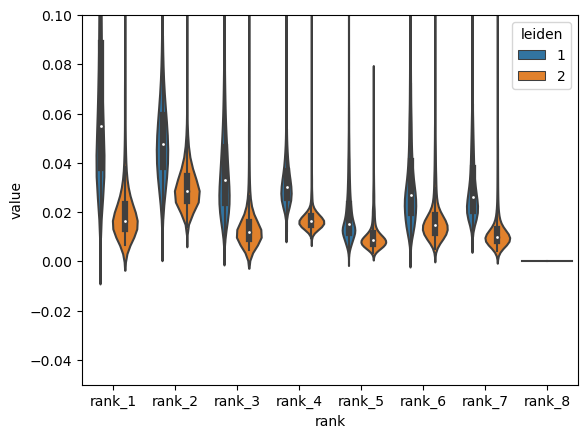

In [127]:
sample_8_dists_melt_df = pd.melt(sample_8_dists_df, id_vars=["leiden"], value_vars=[f"rank_{rank}" for rank in [1, 2, 3, 4, 5, 6, 7, 8]], var_name="rank")
sub_melt_df = sample_8_dists_melt_df[sample_8_dists_melt_df["leiden"].isin([ 1, 2])]
sns.violinplot(x="rank", y="value", hue="leiden", data=sub_melt_df)
plt.ylim((-0.05, 0.1))

<Axes: xlabel='cluster', ylabel='value'>

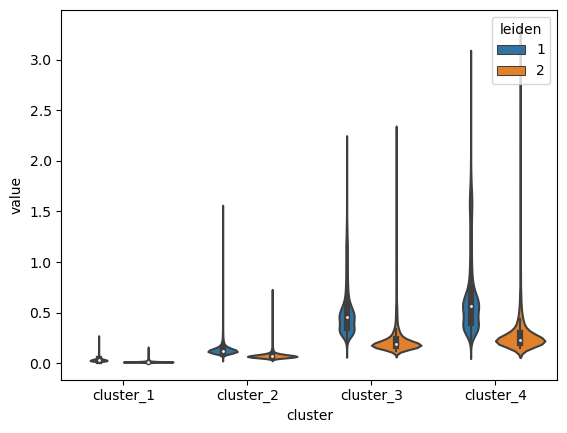

In [128]:
sample_8_dists_melt_df = pd.melt(sample_8_dists_df, id_vars=["leiden"], value_vars=[f"cluster_{cluster}" for cluster in range(1, 5)], var_name="cluster")
sub_melt_df = sample_8_dists_melt_df[sample_8_dists_melt_df["leiden"].isin([1, 2])]
sns.violinplot(x="cluster", y="value", hue="leiden", data=sub_melt_df)